In [2]:
import numpy as np
###list of data files
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time
import math
from itertools import groupby
from operator import itemgetter
import more_itertools as mit
import time
from numpy import array
from numpy.random import rand
import datetime

In [4]:
def collect_cluster_info(clusters_data_list,end_date):
    cluster_info = pd.DataFrame()
    cluster_data = clusters_data_list3[0][['SecurityID','Group']]
    for i in range(1,len(clusters_data_list3)):
        temp  = clusters_data_list3[i][['SecurityID','Group']]
        cluster_data = cluster_data.append(temp,ignore_index=True)
    cluster_info['SecurityID'] = cluster_data['SecurityID']
    cluster_info[end_date] = cluster_data['Group']
    return cluster_info

In [6]:
def check_outlier(x):
    if x > 2 or x < -2:
        return "True"
    else:
        return "False"

In [8]:
def transfer_to_list_of_pd(clusters_list):
    clusters_data_list = []
    for i in clusters_list:
        temp_data = pd.DataFrame(i, columns =['SecurityID', 'Sector', 'Industry','Sub_Industry','Seniority','Issuedby','Country','Rating','AmountIssued','Coupon','IssueDate','MaturityDate','Bond_Term','Term_Type','Cupon_Type','Group'])
        clusters_data_list.append(temp_data)
    return clusters_data_list

In [10]:
def assign_rating(x):
    x = float(x)
    if x < 0:
        return 'NR'
    elif x<=13.5:
        return "Junk"
    elif x>13.5 and x<=16.5:
        return 'Lower medium grade'
    elif x>16.5 and x<=19.5:
        return 'Upper medium grade'
    elif x>19.5 and x<=22.5:
        return 'High grade'
    else:
        return 'Prime'

In [12]:
def process_rating_data(data):
    #data = data[data['KeyDate']<=end_date]
    rating = data.groupby('SecurityID',as_index=False).mean()
    rating['RatingSP'] = rating['RatingSP'].apply(lambda x:assign_rating(x))
    return rating

In [14]:
def grab_clusters(clusters,fdata,security_data,rating_data):
    temp_list = []
    for cluster_index in range(0,len(clusters)):
        temp_list2 = []
        for bond_index in clusters[cluster_index]:
            bond_id = fdata.iloc[bond_index].id
            bond_Sector = security_data[security_data['SecurityID']==bond_id].SecuritySector.iloc[0]
            bond_Industry = security_data[security_data['SecurityID'] == bond_id].SecurityIndustry.iloc[0]
            bond_sub_Industry = security_data[security_data['SecurityID'] == bond_id].SecuritySubIndustry.iloc[0]
            bond_Seniority = security_data[security_data['SecurityID'] == bond_id].Seniority.iloc[0]
            bond_Issuer =security_data[security_data['SecurityID'] == bond_id].Issuer.iloc[0]
            bond_countryrisk =security_data[security_data['SecurityID'] == bond_id].CountryRisk.iloc[0]
            bond_amountIssued =security_data[security_data['SecurityID'] == bond_id].AmountIssued.iloc[0]
            bond_coupon =security_data[security_data['SecurityID'] == bond_id].Coupon.iloc[0]
            bond_MaturityDate = security_data[security_data['SecurityID'] == bond_id].MaturityDate.iloc[0]
            bond_issuedate =security_data[security_data['SecurityID'] == bond_id].IssueDate.iloc[0]
            bond_cupontype = security_data[security_data['SecurityID'] == bond_id].CouponType.iloc[0]
            try:
                bond_term = int(bond_MaturityDate.year) - int(bond_issuedate.year)
            except:
                bond_term = 100
            if bond_term >= 10:
                bond_type_term = 'Long Term'
            elif bond_term < 10 and bond_term >= 5:
                bond_type_term = 'Mid Term'
            else:
                bond_type_term = 'Short Term'
            try:
                bond_rating=rating_data[rating_data['SecurityID'] == bond_id].RatingSP.iloc[0]
            except:
                bond_rating = 'Not Founded'
            bond_cluster = 'Cluster {}' .format(cluster_index)
            temp_tuple = (bond_id,bond_Sector,bond_Industry,bond_sub_Industry,bond_Seniority,bond_Issuer,bond_countryrisk,bond_rating,bond_amountIssued,bond_coupon,bond_issuedate,bond_MaturityDate,bond_term,bond_type_term,bond_cupontype,bond_cluster)
            temp_list2.append(temp_tuple)
        temp_list.append(temp_list2)
    return temp_list

In [16]:
def merge_left_right(data1,data2):
    temp_data = data1.append(data2)
    return temp_data

def merg_sort(list_data):
    list_length = len(list_data)
    if list_length == 1:
        output = list_data[0][2]
        return output
    else:
        mid_point = math.floor(list_length/2)
        #print(len(list_data[:mid_point]))
        left = list_data[mid_point:]
        right = list_data[:mid_point]
        return merge_left_right(merg_sort(left), merg_sort(right))

## Change this part to read data from csv file

In [18]:
import mysql.connector as sql

In [20]:
db_connection = sql.connect(host='0.0.0.0',database='bond_db',user='root',password='password')

In [22]:
query ="select * from bond_spread where  KeyDate between '2018-12-31' and '2019-02-28'"

In [24]:
final_data = pd.read_sql(query,con=db_connection)

In [26]:
security_query = "select * from security_info"
security_data = pd.read_sql(security_query,con=db_connection)
security_dat_part = security_data[['SecurityID','Currency','IssueDate','MaturityDate']]

## END

In [34]:
###left join the currency data into the spread data
final_data = final_data.merge(security_dat_part, on=['SecurityID'], how='left')
final_data.dropna(subset=["ZSpread"],inplace=True)
###select currency as USD
final_data_1 = final_data[final_data.Currency == 'USD']
final_data = final_data_1.groupby('SecurityID')
###create a list of bond with data
bonds_list = [final_data.get_group(x) for x in final_data.groups]

AttributeError: 'DataFrameGroupBy' object has no attribute 'merge'

In [31]:
final_data.head()

,SecurityID,KeyDate,Price,YieldWorst,ModifiedDuration_Plain,WorkoutDate,AmtOutstanding,GSpread,OAS_Spread,ZSpread,AswUsd,Currency,IssueDate,MaturityDate
0,64,2018-12-31,91.0976,6.49918,6.06004,2026-08-15 00:00:00,1.697270e+09,389.1300,345.6040,385.4930,357.6530,USD,2016-08-03 00:00:00,2026-08-15 00:00:00
1,64,2019-01-02,90.8950,6.53581,6.05466,2026-08-15 00:00:00,1.697270e+09,399.4200,351.0100,390.5860,361.9700,USD,2016-08-03 00:00:00,2026-08-15 00:00:00
2,64,2019-01-03,90.8199,6.55070,6.04601,2026-08-15 00:00:00,1.697270e+09,409.2000,365.0100,405.6340,375.7360,USD,2016-08-03 00:00:00,2026-08-15 00:00:00
3,64,2019-01-04,92.0500,6.33260,6.06068,2026-08-15 00:00:00,1.697270e+09,381.5900,329.9220,371.5850,346.8090,USD,2016-08-03 00:00:00,2026-08-15 00:00:00
4,64,2019-01-07,93.4350,6.09098,6.07716,2026-08-15 00:00:00,1.697270e+09,347.3900,300.0140,344.9780,324.9790,USD,2016-08-03 00:00:00,2026-08-15 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599703,64589,2019-01-30,97.7477,3.18076,3.41226,2022-09-19 04:00:00,NaN,71.5754,66.0374,59.0387,57.0995,USD,2018-12-14 05:00:00,2022-09-19 04:00:00
599704,64589,2019-01-31,98.0202,3.10112,3.40582,2022-09-19 04:00:00,NaN,66.7400,64.4305,57.4232,55.8154,USD,2018-12-14 05:00:00,2022-09-19 04:00:00
599705,64589,2019-02-01,97.8827,3.14246,3.40228,2022-09-19 04:00:00,NaN,65.7407,61.8283,55.4225,53.7040,USD,2018-12-14 05:00:00,2022-09-19 04:00:00
599706,64589,2019-02-04,97.8626,3.14893,3.39945,2022-09-19 04:00:00,NaN,62.5585,59.9634,53.7224,52.0289,USD,2018-12-14 05:00:00,2022-09-19 04:00:00


In [33]:
def get_the_windows(bonds_list):
    bond_spread_list = []
    for bond in bonds_list:
        try:
            bond['KeyDate'] = pd.to_datetime(bond['KeyDate'])
            bond = bond.set_index('KeyDate')
            logic = {'GSpread'  : 'last',
                 'SecurityID':'first'}
            offset = pd.offsets.timedelta(days=-6)
            d = bond.resample('W', loffset=offset).apply(logic)
            d['G_change']=d.GSpread.pct_change()
            d.dropna(subset=['G_change'],inplace = True)
            d['outlier'] = d.G_change.apply(check_outlier)
            d.reset_index(inplace=True)
            if "True" not in d['outlier'].values:
                bond_spread_list.append((len(d.GSpread.values),bond.SecurityID.iloc[0],d))
        except:
            pass
    return bond_spread_list

In [ ]:
bond_spread_list = get_the_windows(bonds_list)

In [38]:
print(len(bond_spread_list))

14891


In [40]:
bond_spread_list[0][2]

,KeyDate,GSpread,SecurityID,G_change,outlier
0,2019-01-07,329.24,64,-0.137189,False
1,2019-01-14,300.84,64,-0.086259,False
2,2019-01-21,320.88,64,0.066613,False
3,2019-01-28,320.44,64,-0.001371,False
4,2019-02-04,327.75,64,0.022812,False
5,2019-02-11,308.38,64,-0.059100,False
6,2019-02-18,309.02,64,0.002075,False
7,2019-02-25,301.52,64,-0.024270,False


In [ ]:
sc = MinMaxScaler()

In [41]:
new_data = merg_sort(bond_spread_list)
new_data.dropna(inplace=True)

In [23]:
week_number = max(new_data['SecurityID'].map(new_data['SecurityID'].value_counts()))

In [24]:
new_data = new_data[new_data['SecurityID'].map(new_data['SecurityID'].value_counts())==week_number]

In [25]:
print(len(new_data))

103624


In [26]:
from tsfresh import extract_features
fdata = extract_features(new_data[['SecurityID','KeyDate','G_change']],column_id="SecurityID", column_sort="KeyDate")

Feature Extraction: 100%|██████████| 20/20 [02:56<00:00,  8.83s/it]


In [27]:
fdata1 = fdata.dropna(axis='columns')

In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [30]:
fdata2 = fdata1.loc[:, ~(fdata1 == fdata1.iloc[0]).all()]

In [31]:
from sklearn.preprocessing import normalize,StandardScaler
data_scaled = sc.fit_transform(fdata2.loc[:,'G_change__abs_energy':'G_change__variation_coefficient'])
data_scaled = normalize(data_scaled)

In [32]:
###get the cluster
def create_cluster_list(cluster_index):
    temp_1 = []
    for i in np.unique(cluster_index):
        temp_2 = []
        for n in range(0,len(cluster_index)):
            if cluster_index[n] == i:
                temp_2.append(n)
        temp_1.append(temp_2)
    return temp_1

In [33]:
def process_rating_data(data):
    #data = data[data['KeyDate']<=end_date]
    rating = data.groupby('SecurityID',as_index=False).mean()
    rating['RatingSP'] = rating['RatingSP'].apply(lambda x:assign_rating(x))
    return rating

In [34]:
rating_data = process_rating_data(pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/Rating.csv"))
rating_data.head()

,SecurityID,RatingSP,RatingSPOutlook,RatingSPOutlook.1
0,64,Junk,NaN,NaN
1,72,Junk,NaN,NaN
2,78,Lower medium grade,NaN,NaN
3,82,Lower medium grade,NaN,NaN
4,83,Lower medium grade,NaN,NaN


In [35]:
rating_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/Rating.csv")

In [36]:
rating_data = rating_data[['SecurityID','KeyDate','RatingSP']]
rating_data = process_rating_data(rating_data)

## Change you number of clusters here

In [37]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=24, random_state=10).fit(data_scaled)

## END

In [38]:
kmeans.labels_

array([ 1, 22,  8, ...,  0,  4, 15], dtype=int32)

In [39]:
clusters3 = create_cluster_list(kmeans.labels_)
clusters_list3 = grab_clusters(clusters3,fdata.reset_index(),security_data,rating_data)

In [40]:
clusters_data_list3 = transfer_to_list_of_pd(clusters_list3)

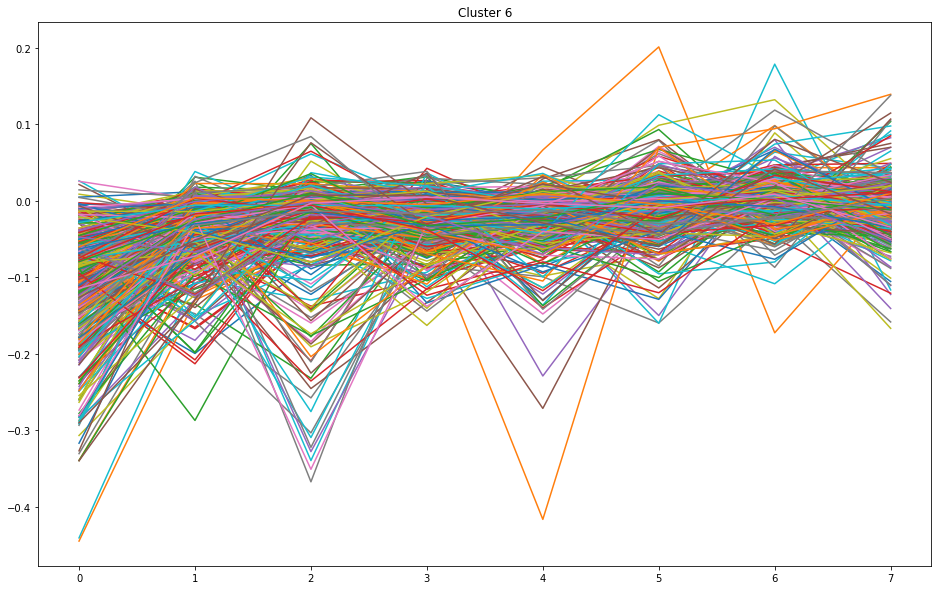

458

In [69]:
a = clusters_data_list3[6]
plt.title('Cluster {}'.format(6))
for c in a['SecurityID']:
    try:
        grpah = new_data[new_data['SecurityID']==c].G_change
        plt.plot(grpah)
    except:
        pass
plt.rcParams["figure.figsize"] = (16,10)
plt.show()
len(a)

In [ ]:
for i in range(0,len(clusters_data_list3)):
    plt.figure()
    plt.title('Cluster {}'.format(i))
    a = clusters_data_list3[i]
    for c in a['SecurityID']:
        try:
            graph = new_data[new_data['SecurityID']==c].G_change
            plt.plot(graph)
        except:
            pass
    plt.rcParams["figure.figsize"] = (16,10)
    plt.savefig('/Users/yangli/OneDrive/MMAI/Capstone/graph/cluster{}.png'.format(i))

from sklearn.metrics import silhouette_score
inertias = {}
silhouettes = {}
for k in range(2, 200):
    kmeans = KMeans(init='k-means++', n_init=10, n_clusters=k, max_iter=1000, random_state=42).fit(data_scaled)
    inertias[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouettes[k] = silhouette_score(data_scaled, kmeans.labels_, metric='euclidean')
    

plt.figure();
plt.grid(True);
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Inertia");


plt.figure();
plt.grid(True);
plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Silhouette");

In [42]:
clusters_data_list3[0]

,SecurityID,Sector,Industry,Sub_Industry,Seniority,Issuedby,Country,Rating,AmountIssued,Coupon,IssueDate,MaturityDate,Bond_Term,Term_Type,Cupon_Type,Group
0,109.0,Communications,Wireless Telecommunications Services,Telephone-Integrated,Sr Unsecured,AT&T INC,US,Lower medium grade,2.000000e+09,4.250,2017-02-09,2027-03-01,10,Long Term,FIXED,Cluster 0
1,135.0,Financials,Banks,Commer Banks-Eastern US,Sr Unsecured,CIT GROUP INC,US,Junk,1.250000e+09,5.000,2012-08-03,2022-08-15,10,Long Term,FIXED,Cluster 0
2,160.0,Financials,Banks,Commer Banks Non-US,Subordinated Unsecured,SANTANDER UK PLC,GB,Lower medium grade,1.500000e+09,5.000,2013-11-07,2023-11-07,10,Long Term,FIXED,Cluster 0
3,267.0,Financials,Banks,Diversified Banking Inst,Sr Unsecured,CREDIT SUISSE GROUP FUNDING GUERNSEY LTD,CH,Lower medium grade,1.995740e+09,3.800,2016-11-16,2023-06-09,7,Mid Term,FIXED,Cluster 0
4,339.0,Communications,Wireless Telecommunications Services,Telephone-Integrated,Sr Unsecured,VERIZON COMMUNICATIONS INC,US,Lower medium grade,1.500000e+09,5.500,2017-03-16,2047-03-16,30,Long Term,FIXED,Cluster 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,53971.0,Energy,Refining & Marketing,Oil Refining&Marketing,Sr Unsecured,ULTRAPAR INTERNATIONAL SA,BR,Junk,7.500000e+08,5.250,2016-10-06,2026-10-06,10,Long Term,FIXED,Cluster 0
828,53980.0,Industrials,Electrical Equipment Manufacturing,Diversified Manufact Op,Sr Unsecured,SIEMENS FINANCIERINGSMAATSCHAPPIJ NV,DE,Upper medium grade,1.500000e+09,3.250,2015-05-27,2025-05-27,10,Long Term,FIXED,Cluster 0
829,53982.0,Industrials,Electrical Equipment Manufacturing,Diversified Manufact Op,Sr Unsecured,SIEMENS FINANCIERINGSMAATSCHAPPIJ NV,DE,Not Founded,7.500000e+08,2.000,2016-09-15,2023-09-15,7,Mid Term,FIXED,Cluster 0
830,55881.0,Energy,Exploration & Production,Oil Comp-Explor&Prodtn,Sr Unsecured,OIL AND GAS HOLDING CO BSCC/THE,BH,Not Founded,5.000000e+08,8.375,2018-11-07,2028-11-07,10,Long Term,FIXED,Cluster 0


## GET the Cluster data through the year

In [43]:
clusters_data_list3[2].head()

,SecurityID,Sector,Industry,Sub_Industry,Seniority,Issuedby,Country,Rating,AmountIssued,Coupon,IssueDate,MaturityDate,Bond_Term,Term_Type,Cupon_Type,Group
0,95.0,Financials,Financial Services,Finance-Invest Bnkr/Brkr,Sr Unsecured,LPL HOLDINGS INC,US,Junk,9.000000e+08,5.750,2017-03-10,2025-09-15,8,Mid Term,FIXED,Cluster 2
1,110.0,Communications,Wireline Telecommunications Services,Telephone-Integrated,Sr Unsecured,FRONTIER COMMUNICATIONS CORP,US,Junk,2.183430e+09,10.500,2016-06-02,2022-09-15,6,Mid Term,FIXED,Cluster 2
2,383.0,Energy,Utilities,Electric-Integrated,Sr Unsecured,EDP FINANCE BV,PT,Lower medium grade,1.000000e+09,4.900,2009-09-29,2019-10-01,10,Long Term,FIXED,Cluster 2
3,1955.0,Auto,Automobiles Manufacturing,Auto-Cars/Light Trucks,Sr Unsecured,GENERAL MOTORS FINANCIAL CO INC,US,Lower medium grade,1.250000e+09,3.450,2017-01-17,2022-01-14,5,Mid Term,FIXED,Cluster 2
4,2056.0,Technology,Hardware,Computers,Sr Unsecured,DELL INTERNATIONAL LLC / EMC CORP,US,Junk,1.625000e+09,5.875,2016-06-22,2021-06-15,5,Mid Term,FIXED,Cluster 2


In [61]:
a = clusters_data_list3[1].groupby(['Country','Rating','Sector','Seniority','Term_Type']).count()
print(len(clusters_data_list3[1]))
a['SecurityID']['US']['Upper medium grade']

680


Sector           Seniority               Term_Type 
Auto             Sr Unsecured            Mid Term       2
Basic Materials  Sr Unsecured            Long Term      3
                                         Mid Term       2
Communications   Sr Unsecured            Long Term      4
                                         Mid Term       2
Consumers        1st Lien Secured        Long Term      3
                 Sr Unsecured            Long Term     13
                                         Mid Term       2
Energy           1st Lien Secured        Long Term      2
                 Secured                 Long Term     24
                                         Mid Term       3
                                         Short Term     1
                 Sr Unsecured            Long Term     18
Financials       1st Lien Secured        Mid Term       1
                 Secured                 Long Term      1
                                         Mid Term       1
                 Sr 

In [62]:
a = clusters_data_list3[0].groupby(['Country','Rating','Sector','Seniority','Term_Type']).count()
print(len(clusters_data_list3[0]))
a['SecurityID']['US']['Upper medium grade']

832


Sector           Seniority               Term_Type 
Auto             Sr Unsecured            Mid Term       1
                                         Short Term     1
Basic Materials  Sr Unsecured            Long Term      2
Communications   Sr Unsecured            Long Term      7
                                         Mid Term       3
Consumers        Sr Unsecured            Long Term     10
Energy           Secured                 Long Term      6
                 Sr Unsecured            Long Term      4
                                         Short Term     1
Financials       Sr Unsecured            Long Term     49
                                         Mid Term      20
                                         Short Term     4
                 Subordinated Unsecured  Long Term      5
Health Care      Sr Unsecured            Long Term     17
                                         Mid Term       4
                                         Short Term     2
Industrials      Sr 

In [54]:
a = clusters_data_list3[4].groupby(['Country','Rating','Sector','Seniority','Term_Type']).count()
print(len(clusters_data_list3[4]))
a[a['SecurityID']>=0.02]['SecurityID']['US']['Upper medium grade']

284


Sector           Seniority     Term_Type 
Auto             Sr Unsecured  Short Term    1
Basic Materials  Sr Unsecured  Long Term     2
Consumers        Sr Unsecured  Long Term     2
Energy           Secured       Long Term     6
                               Mid Term      1
                               Short Term    1
                 Sr Unsecured  Long Term     6
Financials       Sr Unsecured  Long Term     1
                               Mid Term      1
Health Care      Sr Unsecured  Long Term     1
                               Mid Term      1
Industrials      Sr Unsecured  Long Term     2
Name: SecurityID, dtype: int64

In [63]:
a = clusters_data_list3[5].groupby(['Country','Rating','Sector','Seniority','Term_Type']).count()
print(len(clusters_data_list3[5]))
a[a['SecurityID']>=0.02]['SecurityID']['US']['Upper medium grade']

755


Sector           Seniority               Term_Type 
Auto             Sr Unsecured            Long Term      1
                                         Mid Term       1
Basic Materials  Sr Unsecured            Long Term      1
                                         Mid Term       3
                                         Short Term     1
Communications   Sr Unsecured            Long Term      4
                                         Mid Term       2
Consumers        Sr Unsecured            Long Term     25
                                         Mid Term       2
Energy           Secured                 Long Term     34
                                         Mid Term       1
                 Sr Unsecured            Long Term     20
Financials       Secured                 Short Term     1
                 Sr Unsecured            Long Term     29
                                         Mid Term      11
                                         Short Term     7
                 Sub

In [55]:
cluster_info = pd.DataFrame()

In [56]:
d1 = collect_cluster_info(clusters_data_list3[0],'2019-02-28')

In [57]:
d1

,SecurityID,2019-02-28
0,109.0,Cluster 0
1,135.0,Cluster 0
2,160.0,Cluster 0
3,267.0,Cluster 0
4,339.0,Cluster 0
...,...,...
12948,53691.0,Cluster 23
12949,53822.0,Cluster 23
12950,53992.0,Cluster 23
12951,54006.0,Cluster 23
